### Imports

In [1]:
import pandas as pn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow import keras
from keras.layers import Conv1D, Input, BatchNormalization, Add, GaussianNoise, Activation, Dropout, Dense, GlobalAveragePooling1D, Multiply
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K


/home/yahoo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yahoo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yahoo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yahoo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

### Load the data as expected
Data can't be shared unfortunately

In [2]:
train_path = "train_lofi_rowid_Nov13.csv"
trainDF = pn.read_csv(train_path)
final_test_path = "test_lofi_rowid_Nov13.csv"
testDF = pn.read_csv(final_test_path)

### Prepare the data
each x in X is a 1100 dimensional vector corresponding to the GR readings at each well depth. There will be 4000 entries in X.

each y in Y is ground truth at that depth

In [3]:
grouped_gr = trainDF[['well_id', 'GR', 'label']].groupby('well_id').apply(lambda x: x['GR'])
grouped_label = trainDF[['well_id', 'GR', 'label']].groupby('well_id').apply(lambda x: x['label'])

X = []
Y = []

for i in range(0, 4000):
    X.append(grouped_gr[i].values)
    Y.append(grouped_label[i].values)
X = np.array(X)
Y = np.array(Y)

### Standard Scale the Data
Neural Nets usually benefit from subtracting the mean and dividing by the standard deviation. Technically, we should do this independently the for each validation split, but for now this is ok for now

In [4]:
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

### Convert to Categorical Data

In [5]:
Y = to_categorical(Y, num_classes=5)

### Define the model
The model is is a resnet-like convolutional neural net, except that it is 1D instead of 2D and we do not use maxpooling, since the output dimension is the same as the input dimension. The input is 1100 GR readings and the output is 1100 predictions.

The model architecture was discovered by trial and error -- making a model large enough to memorize the dataset (that is an indicator it has enough expresive power to model the problem) but not so large that it takes a long time to train.

In [6]:
def get_model():
    def SqueezeExcite(x, ratio=16):
        nb_chan = K.int_shape(x)[-1]

        y = GlobalAveragePooling1D()(x)
        y = Dense(nb_chan // ratio, kernel_initializer='he_normal', activation='relu')(y)
        y = Dense(nb_chan, kernel_initializer='he_normal', activation='sigmoid')(y)

        y = Multiply()([x, y])
        return y

    inputs = Input((1100,1))
    noised_inputs = GaussianNoise(0.01)(inputs)

    CHANNELS = 64
    FILTER_SIZE = 15
    DROP_RATE = 0.1
    
    conv_x = Conv1D(CHANNELS, FILTER_SIZE, strides=1, padding='same', kernel_regularizer=l2(1e-5), kernel_initializer='he_normal')(noised_inputs)
    conv_x = GaussianNoise(0.1)(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Dropout(DROP_RATE)(conv_x)
    for i in range(36):

        conv_i = Conv1D(CHANNELS, FILTER_SIZE, strides=1, padding='same', kernel_regularizer=l2(1e-5), kernel_initializer='he_normal')(conv_x)
        conv_i = GaussianNoise(0.1)(conv_i)
        conv_i = Activation('relu')(conv_i)
        conv_i = BatchNormalization()(conv_i)
        conv_i = Dropout(DROP_RATE)(conv_i)
        
        conv_i = SqueezeExcite(conv_i)

        conv_i = Conv1D(CHANNELS, FILTER_SIZE, strides=1, padding='same', kernel_regularizer=l2(1e-5), kernel_initializer='he_normal')(conv_i)
        conv_i = GaussianNoise(0.1)(conv_i)
        conv_i = Activation('relu')(conv_i)
        conv_i = BatchNormalization()(conv_i)
        conv_i = Dropout(DROP_RATE)(conv_i)

        conv_i = SqueezeExcite(conv_i)
        
        conv_x = Add()([conv_x, conv_i])

    conv_x = SqueezeExcite(conv_x)
    conv_f = Conv1D(5, FILTER_SIZE, strides=1, padding='same', activation='softmax', kernel_regularizer=l2(1e-5), kernel_initializer='he_normal')(conv_x)


    model = Model(input=inputs, output=conv_f)
    
    model.compile(optimizer = Adam(lr = 3e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

### Do a k-fold Split
It's standard practice to divide the dataset into _k_ partitions then train _k_ models, each having one of the partitions held out for validation. We will then ensemble the _k_ models together. That way, our final model has seen the entire dataset, but isn't overfitted to it.

On a desktop running a GTX 1070, it takes about 34s / epoch and about 90 epochs before early stopping kicks in. For k=4, that translates to about 3.4 hours of training time.

In [23]:
%%time
models_dumb = []
kf = KFold(n_splits=5)
counter = 1
for train_index, test_index in kf.split(X_std):
    if counter <= 4:
        counter += 1
        continue
    X_train, X_test = X_std[train_index], X_std[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=12)

    model = get_model()
    model.fit(x=np.expand_dims(X_train, axis=-1), y=y_train, validation_data=(np.expand_dims(X_test, axis=-1), y_test), epochs=300, callbacks=[reduce_lr, early_stopping])
    models_dumb.append(model)

/home/yahoo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 3200 samples, validate on 800 samples
Epoch 1/300
3200/3200 [==============================] - 139s 43ms/step - loss: 0.2172 - accuracy: 0.9610 - val_loss: 0.2217 - val_accuracy: 0.9539
Epoch 2/300
3200/3200 [==============================] - 87s 27ms/step - loss: 0.1452 - accuracy: 0.9822 - val_loss: 0.1494 - val_accuracy: 0.9790
Epoch 3/300
3200/3200 [==============================] - 87s 27ms/step - loss: 0.1353 - accuracy: 0.9851 - val_loss: 0.1315 - val_accuracy: 0.9858
Epoch 4/300
3200/3200 [==============================] - 88s 27ms/step - loss: 0.1283 - accuracy: 0.9870 - val_loss: 0.1228 - val_accuracy: 0.9886
Epoch 5/300
3200/3200 [==============================] - 88s 27ms/step - loss: 0.1241 - accuracy: 0.9879 - val_loss: 0.1239 - val_accuracy: 0.9879
Epoch 6/300
3200/3200 [==============================] - 87s 27ms/step - loss: 0.1198 - accuracy: 0.9888 - val_loss: 0.1220 - val_accuracy: 0.9882
Epoch 7/300
3200/3200 [==============================] - 87s 27ms/step

In [25]:
models

In [26]:
models_dumb

In [28]:
%%time
def predict_on_data(data):
    results = []
    for model in models + models_dumb:
        print("predict...")
        result = model.predict(np.expand_dims(data, axis=-1))
        results.append(result)

    # Average the results together, then take the index of the highest value
    return np.argmax(sum(results) / len(models), axis=-1)  

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 7.87 µs


In [29]:
test_well_ids = testDF.well_id.unique()
X_test = []
for well_id in test_well_ids:
    GR = testDF[testDF.well_id == well_id].GR.values
    X_test.append(GR)
X_test = np.array(X_test)

X_test_std = scaler.transform(X_test)

In [30]:
np.mean(X_test_std)

-0.034528409659228175

In [31]:
submission_values = predict_on_data(X_test_std)
np.save('submission_values.npy', submission_values)

predict...
predict...
predict...
predict...
predict...


In [32]:
submission_values.flatten()

array([0, 0, 0, ..., 0, 0, 0])

(array([202462.,      0.,  45135.,      0.,      0.,  45508.,      0.,
         45253.,      0.,  46642.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

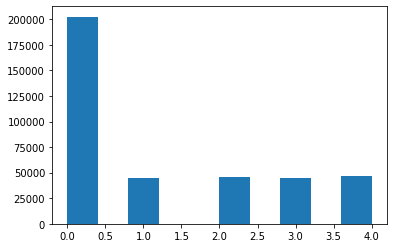

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(submission_values.flatten())

In [34]:
submission_values.shape

(350, 1100)

In [35]:
testDF["PredictedLabel"] = submission_values.flatten()
testDF[["row_id","well_id","PredictedLabel"]].to_csv("submission.csv", index=False)

In [36]:
testDF

,row_id,well_id,GR,PredictedLabel
0,0,5000,134.943504,0
1,1,5000,127.004675,0
2,2,5000,133.159255,0
3,3,5000,134.411762,0
4,4,5000,135.748644,0
...,...,...,...,...
384995,1095,5349,134.221769,0
384996,1096,5349,135.804491,0
384997,1097,5349,126.124399,0
384998,1098,5349,117.591583,0
